In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet152

import datetime

In [2]:
currentPath = os.getcwd()
print(currentPath)

C:\Users\CARLOS CORDERO\Desktop\ToG_pretrain


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


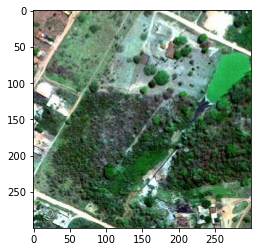

In [4]:
trainDB = currentPath + os.sep + "train20"
valDB = currentPath + os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
Resnet152WeightsPretrained = currentPath + os.sep + "resnet152_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_name = "Resnet152"
classList = os.listdir(trainDB)

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_7_8_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00008
batch_size = 10
num_epochs = 200
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = len(classList)

In [6]:
tensorboardLogsPath = "logs" + os.sep + "fit" + os.sep + model_name + os.sep + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "-lr-" + str(lr)
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=tensorboardLogsPath, histogram_freq=1)

In [7]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 105 images belonging to 7 classes.
Found 34 images belonging to 7 classes.


In [8]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6}


In [9]:
input = Input(shape=(img_rows, img_cols, img_channel))

In [10]:
def ResnetCustom(shape,pretrainedweights, input_tensor, classes):
    RN152NoTop = ResNet152(
        include_top=False, weights=pretrainedweights, input_tensor=input_tensor, input_shape=shape)
    
    RN152Out = RN152NoTop.layers[-1].output
    x = GlobalAvgPool2D()(RN152Out)
    output = Dense(classes, activation="softmax")(x)
    model = Model(input_tensor, output)
        
    return model

In [11]:
model = ResnetCustom((img_rows, img_cols, img_channel),Resnet152WeightsPretrained, input, num_categories)

model.summary()
#plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Non-trainable params: 151,424
__________________________________________________________________________________________________


In [12]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[ReduceLROnPlateau(), tensorflow.keras.callbacks.TensorBoard("logs/sample" + "/keras1")],
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
4/4 [==============================] - 5s 1s/step - loss: 2.0875 - accuracy: 0.1250 - val_loss: 2.5230 - val_accuracy: 0.1471 - lr: 8.0000e-05
Epoch 2/200
4/4 [==============================] - 2s 589ms/step - loss: 1.7729 - accuracy: 0.2000 - val_loss: 3.3913 - val_accuracy: 0.1176 - lr: 8.0000e-05
Epoch 3/200
4/4 [==============================] - 4s 987ms/step - loss: 1.2219 - accuracy: 0.6286 - val_loss: 4.1684 - val_accuracy: 0.1176 - lr: 8.0000e-05
Epoch 4/200
4/4 [==============================] - 2s 587ms/step - loss: 1.2805 - accuracy: 0.5500 - val_loss: 4.6514 - val_accuracy: 0.0882 - lr: 8.0000e-05
Epoch 5/200
4/4 [==============================] - 2s 591ms/step - loss: 1.1749 - accuracy: 0.6000 - val_loss: 3.4827 - val_accuracy: 0.1471 - lr: 8.0000e-05
Epoch 6/200
4/4 [==============================] - 2s 592ms/step - loss: 0.7099 - accuracy: 0.8000 - val_loss: 2.8848 - val_accuracy: 0.1

Epoch 51/200
4/4 [==============================] - 2s 599ms/step - loss: 0.1097 - accuracy: 1.0000 - val_loss: 2.2517 - val_accuracy: 0.1765 - lr: 8.0000e-08
Epoch 52/200
4/4 [==============================] - 2s 536ms/step - loss: 0.2203 - accuracy: 0.9429 - val_loss: 2.3330 - val_accuracy: 0.1471 - lr: 8.0000e-08
Epoch 53/200
4/4 [==============================] - 2s 600ms/step - loss: 0.1586 - accuracy: 0.9500 - val_loss: 2.2642 - val_accuracy: 0.1471 - lr: 8.0000e-09
Epoch 54/200
4/4 [==============================] - 2s 601ms/step - loss: 0.1127 - accuracy: 1.0000 - val_loss: 2.3276 - val_accuracy: 0.1765 - lr: 8.0000e-09
Epoch 55/200
4/4 [==============================] - 2s 539ms/step - loss: 0.1492 - accuracy: 0.9714 - val_loss: 2.1359 - val_accuracy: 0.2353 - lr: 8.0000e-09
Epoch 56/200
4/4 [==============================] - 2s 598ms/step - loss: 0.1342 - accuracy: 0.9500 - val_loss: 2.2211 - val_accuracy: 0.1471 - lr: 8.0000e-09
Epoch 57/200
4/4 [============================

4/4 [==============================] - 2s 543ms/step - loss: 0.1847 - accuracy: 0.9714 - val_loss: 2.8034 - val_accuracy: 0.1176 - lr: 8.0000e-13
Epoch 103/200
4/4 [==============================] - 2s 603ms/step - loss: 0.2282 - accuracy: 0.9250 - val_loss: 2.5899 - val_accuracy: 0.1176 - lr: 8.0000e-13
Epoch 104/200
4/4 [==============================] - 2s 603ms/step - loss: 0.1853 - accuracy: 0.9500 - val_loss: 2.6865 - val_accuracy: 0.0588 - lr: 8.0000e-13
Epoch 105/200
4/4 [==============================] - 2s 603ms/step - loss: 0.1553 - accuracy: 0.9429 - val_loss: 2.7178 - val_accuracy: 0.1176 - lr: 8.0000e-13
Epoch 106/200
4/4 [==============================] - 2s 605ms/step - loss: 0.3327 - accuracy: 0.8750 - val_loss: 2.6724 - val_accuracy: 0.1176 - lr: 8.0000e-14
Epoch 107/200
4/4 [==============================] - 2s 545ms/step - loss: 0.1995 - accuracy: 0.9429 - val_loss: 2.7100 - val_accuracy: 0.1176 - lr: 8.0000e-14
Epoch 108/200
4/4 [==============================] - 2

4/4 [==============================] - 2s 607ms/step - loss: 0.2371 - accuracy: 0.9250 - val_loss: 3.1290 - val_accuracy: 0.1471 - lr: 8.0000e-18
Epoch 154/200
4/4 [==============================] - 2s 546ms/step - loss: 0.1765 - accuracy: 0.9714 - val_loss: 3.3886 - val_accuracy: 0.0882 - lr: 8.0000e-18
Epoch 155/200
4/4 [==============================] - 2s 606ms/step - loss: 0.1139 - accuracy: 0.9750 - val_loss: 3.1713 - val_accuracy: 0.1471 - lr: 8.0000e-18
Epoch 156/200
4/4 [==============================] - 2s 606ms/step - loss: 0.1408 - accuracy: 1.0000 - val_loss: 3.0732 - val_accuracy: 0.1176 - lr: 8.0000e-19
Epoch 157/200
4/4 [==============================] - 2s 546ms/step - loss: 0.2831 - accuracy: 0.9143 - val_loss: 3.0489 - val_accuracy: 0.1471 - lr: 8.0000e-19
Epoch 158/200
4/4 [==============================] - 2s 607ms/step - loss: 0.1592 - accuracy: 0.9750 - val_loss: 2.9915 - val_accuracy: 0.1176 - lr: 8.0000e-19
Epoch 159/200
4/4 [==============================] - 2

In [14]:
model.save(currentPath + os.sep + "Resnet152Model.h5")
model.save_weights(currentPath + os.sep + "Resnet152Weights.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


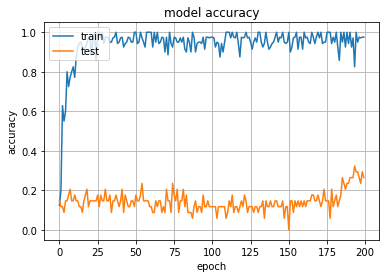

In [15]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

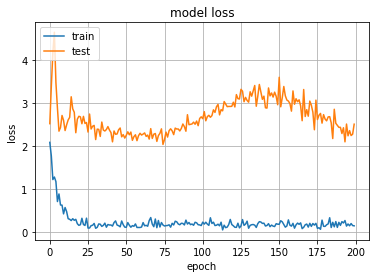

In [16]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [17]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( img_rows, img_cols))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_45_3_msrgb.jpg is: airport
file airport_55_0_msrgb.jpg is: airport
file airport_6_0_msrgb.jpg is: airport


In [18]:
loadedModel = load_model("Resnet152Model.h5")

path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( img_rows, img_cols))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_45_3_msrgb.jpg is: airport
file airport_55_0_msrgb.jpg is: airport
file airport_6_0_msrgb.jpg is: airport
